## Covering all model components
* mean model --> so far: Zero mean, try out ARIMA
* volatility model --> GARCH
* distribution --> normal distributed

Followed this article:
https://medium.com/analytics-vidhya/arima-garch-forecasting-with-python-7a3f797de3ff

In [2]:
from arch import arch_model
from datetime import timedelta
import pandas as pd
import numpy as np

from evaluation.help_functions.prepare_data import most_recent_thursday, next_working_days
from dax.help_functions.get_dax_data import get_prepared_data
#from dax.help_functions.get_quantiles import get_norm_quantiles
from dax.help_functions.get_dax_data import get_data

In [43]:
daxdata = get_prepared_data()
daxdata

,Close,LogRetLag1,LogRetLag2,LogRetLag3,LogRetLag4,LogRetLag5
Date,,,,,,
2019-09-10 00:00:00+02:00,12268.709961,0.347914,0.629422,1.163586,2.006097,2.960150
2019-09-11 00:00:00+02:00,12359.070312,0.733812,1.081725,1.363234,1.897398,2.739909
2019-09-12 00:00:00+02:00,12410.250000,0.413251,1.147063,1.494977,1.776485,2.310649
2019-09-13 00:00:00+02:00,12468.530273,0.468515,0.881766,1.615578,1.963491,2.245000
2019-09-16 00:00:00+02:00,12380.309570,-0.710062,-0.241547,0.171704,0.905516,1.253429
...,...,...,...,...,...,...
2024-01-18 00:00:00+01:00,16567.349609,0.822211,-0.026133,-0.330653,-0.824790,0.122728
2024-01-19 00:00:00+01:00,16555.130859,-0.073779,0.748432,-0.099912,-0.404432,-0.898569
2024-01-22 00:00:00+01:00,16683.359375,0.771570,0.697791,1.520002,0.671658,0.367138


LogRetLag1 ---> 1. Prediction at t
LogRegLag2 --> 2. Prediction at t
LogRetLag3 --> 3. Prediction at t

## Mean Component 
* Find ARIMA-order for each Horizon
* Use Library PMDARIMA, IC = AIC, BIC; stationary default = False --> Check thorugh test, if stationary, d can be set to zero (even if we know through return values)
* Unter beiden Kriterien folgende Order: 
{'LogRetLag1': (0, 0, 0),
 'LogRetLag2': (5, 0, 0),
 'LogRetLag3': (5, 0, 1),
 'LogRetLag4': (5, 0, 0),
 'LogRetLag5': (5, 0, 2)}


In [26]:
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import numpy as np

def test_stationarity(daxdata):
    # Berechnung der Log-Renditen

    # Durchführung des Augmented Dickey-Fuller-Tests
    result = adfuller(daxdata['LogRetLag1'], autolag='AIC')

    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Überprüfung des p-Werts
    if result[1] <= 0.05:
        print("Die Zeitreihe der Log-Renditen ist stationär.")
    else:
        print("Die Zeitreihe der Log-Renditen ist nicht stationär.")

# Stationaritätstest durchführen
test_stationarity(daxdata)

ADF Statistic: -8.074532544987864
p-value: 1.5179612772993655e-12
Critical Values: {'1%': -3.436402509014354, '5%': -2.8642124318084456, '10%': -2.568192893555997}
Die Zeitreihe der Log-Renditen ist stationär.


Find optimal ARIMA order using pmdarima: The great thing about pmdarima is that it finds the optimal ARIMA(p, d, q) parameters for you, whereas the statsmodels package forces you to manually find the optimal parameters
AIC and BIC --> Account for both, sharpness and variance

In [29]:
import pmdarima
import statsmodels as sm

order_dict_aic = {}
for h in ['LogRetLag1', 'LogRetLag2', 'LogRetLag3', 'LogRetLag4','LogRetLag5']:
    # fit ARIMA on returns, AIC = default
    arima_model_fitted = pmdarima.auto_arima(daxdata[h], stationary=True)
    order_dict_aic.update({h: arima_model_fitted.order})

order_dict_aic

{'LogRetLag1': (0, 0, 0),
 'LogRetLag2': (5, 0, 0),
 'LogRetLag3': (5, 0, 1),
 'LogRetLag4': (5, 0, 0),
 'LogRetLag5': (5, 0, 2)}

In [30]:
order_dict_bic = {}
for h in ['LogRetLag1', 'LogRetLag2', 'LogRetLag3', 'LogRetLag4', 'LogRetLag5']:
    # fit ARIMA on returns
    arima_model_fitted = pmdarima.auto_arima(daxdata[h], stationary=True, information_criterion='bic')
    order_dict_bic.update({h: arima_model_fitted.order})
order_dict_bic

{'LogRetLag1': (0, 0, 0),
 'LogRetLag2': (5, 0, 0),
 'LogRetLag3': (5, 0, 1),
 'LogRetLag4': (1, 0, 0),
 'LogRetLag5': (5, 0, 2)}

In [64]:
from sklearn.metrics import r2_score

order_dict_aic = {}
r_squared_dict = {}

for h in ['LogRetLag1', 'LogRetLag2', 'LogRetLag3', 'LogRetLag4', 'LogRetLag5']:
    # Fit ARIMA on returns, AIC = default
    arima_model_fitted = pmdarima.auto_arima(daxdata[h], stationary=True)
    order_dict_aic.update({h: arima_model_fitted.order})

    # Generate predictions using the fitted ARIMA model
    predicted_values = arima_model_fitted.predict_in_sample()

    # Placeholder for actual values (replace this with your actual data)
    actual_values = daxdata[h]

    # Calculate R-squared
    r_squared = r2_score(actual_values, predicted_values)
    r_squared_dict.update({h: r_squared})

order_dict_aic, r_squared_dict

({'LogRetLag1': (0, 0, 0),
  'LogRetLag2': (5, 0, 0),
  'LogRetLag3': (5, 0, 1),
  'LogRetLag4': (5, 0, 0),
  'LogRetLag5': (5, 0, 2)},
 {'LogRetLag1': -0.0004484213461006803,
  'LogRetLag2': 0.3905716490887319,
  'LogRetLag3': 0.5497338689967319,
  'LogRetLag4': 0.6668563642437788,
  'LogRetLag5': 0.7353384667626648})

In [82]:
mean_comp = pd.DataFrame({"p": [0, 5,5,5,5],
                   "q": [0,0,1,0,2], 
                   'R2': [ -0.0004, 0.3906, 0.5497, 0.6669, 0.7353]})
mean_comp.index = ['Horizon 1', 'Horizon 2', 'Horizon 3', 'Horizon 4', 'Horizon 5']
mean_comp

,p,q,R2
Horizon 1,0,0,-0.0004
Horizon 2,5,0,0.3906
Horizon 3,5,1,0.5497
Horizon 4,5,0,0.6669
Horizon 5,5,2,0.7353


Glücklicherweise selbe order bei beiden Kriterien --> Nutze diese!  
D irrelevant --> Results for ARMA(p,q) 

## Volatility Component 
Find best p and q  --> just for me to see how to combine ARMA and GARCH

In [ ]:
import pmdarima
import numpy as np
import arch
from sklearn.metrics import r2_score

# Define a range for GARCH orders
p_values = range(1, 5)  # adjust as needed
q_values = range(1, 5)  # adjust as needed

best_orders_aic = {}
best_orders_bic = {}

# Store actual and predicted values for R-squared calculation
actual_values = []
predicted_values = []

for h in [1, 2, 3, 4, 5]:
    # ARIMA model
    temp_model = pmdarima.auto_arima(
        daxdata.iloc[:, h], suppress_warnings=True)
    temp_residuals = temp_model.arima_res_.resid

    # GARCH model
    garch_temp = arch.arch_model(
        temp_residuals, p=1, q=1, dist='t')
    garch_fitted = garch_temp.fit(disp='off')

    # Forecasting
    predicted_mu = temp_model.predict(n_periods=h).iloc[-1]
    garch_forecast = garch_fitted.forecast(horizon=h)
    horizon_name = f'h.{h}'
    predicted_et = garch_forecast.mean[horizon_name].iloc[-1]

    # Final prediction
    prediction = predicted_mu + predicted_et

    print(f"{h} - ARIMA Order: {temp_model.order}, GARCH Order: (1, 1)")
    print("Final Prediction:", prediction)
    predicted_values.append(prediction)


In [ ]:
temp_model.predict(n_periods=h)

## Now: Optimize GARCH Parameters based on AIC and BIC
Alternative GARCH Model with optimized GARCH Parameters und mean=zero, bc. sklearns r2 when splitting data is negative 
explains that R2 can be negative if the model's predictions are worse than a horizontal line representing the mean of the target variable (appr -1.86)

In [ ]:
import arch
# Define a range for GARCH orders
p_values = range(1, 5)  # adjust as needed
q_values = range(1, 5)  # adjust as needed

best_orders_aic={}
best_orders_bic={}

for h in ['LogRegLag1', 'LogRetLag2', 'LogRetLag3', 'LogRetLag4', 'LogRetLag5']:
    # Grid search for best GARCH orders using AIC
   
    best_aic = float("inf")
    best_order = None

    for p in p_values:
        for q in q_values:
            model = arch.arch_model(daxdata[h], mean='zero', vol='Garch', p=p, q=q, dist='t')
            result = model.fit(disp='off')
            aic = result.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
    best_orders_aic.update({f'Horizon {h}': [best_aic, best_order]})

    best_bic = float("inf")
    best_order = None

    for p in p_values:
        for q in q_values:
            model = arch.arch_model(daxdata[h], mean='zero',vol='Garch', p=p, q=q, dist='t')
            result = model.fit(disp='off')
            bic = result.bic
            if bic < best_bic:
                best_bic = bic
                best_order = (p, q)
    best_orders_bic.update({f'Horizon {h}': [best_bic, best_order]})

In [38]:
best_orders_aic

{'LogRetLag1': [3347.8122057931605, (1, 1)],
 'LogRetLag2': [4034.7293020263123, (1, 4)],
 'LogRetLag3': [4416.134001861819, (1, 4)],
 'LogRetLag4': [4582.280020593924, (1, 4)],
 'LogRetLag5': [4720.3103765121, (1, 4)]}

In [39]:
best_orders_bic

{'LogRetLag1': [3367.8750554751095, (1, 1)],
 'LogRetLag2': [4060.839573444611, (1, 2)],
 'LogRetLag3': [4442.014469627357, (1, 2)],
 'LogRetLag4': [4610.9058713170025, (1, 2)],
 'LogRetLag5': [4755.1826157621645, (1, 2)]}

Find best order using optimal ARMA model

In [85]:
mean_zero = pd.DataFrame({"p": [1,1,1,1,1],
                        "q": [1,2,2,2,2],
                        'BIC': [3367.8751, 4060.8396, 4442.0147,4610.9059, 4755.1827]})
mean_zero.index = ['Horizon 1', 'Horizon 2',
                   'Horizon 3', 'Horizon 4', 'Horizon 5']
mean_zero

,p,q,BIC
Horizon 1,1,1,3367.8751
Horizon 2,1,2,4060.8396
Horizon 3,1,2,4442.0147
Horizon 4,1,2,4610.9059
Horizon 5,1,2,4755.1827


In [44]:
daxdata.columns

Index(['Close', 'LogRetLag1', 'LogRetLag2', 'LogRetLag3', 'LogRetLag4',
       'LogRetLag5'],
      dtype='object')

In [70]:
import arch
# Define a range for GARCH orders
p_values = range(1, 5)  # adjust as needed
q_values = range(0, 5)  # adjust as needed

best_orders_aic = {}
best_orders_bic = {}
fitted_models = {}
for h in ['LogRetLag1', 'LogRetLag2', 'LogRetLag3', 'LogRetLag4', 'LogRetLag5']:
    # Grid search for best GARCH orders using AIC

    best_aic = float("inf")
    best_order = None

    for p in p_values:
        for q in q_values:

            name = f'{h}_Garch({p},{q})'
            model = arch.arch_model(
                daxdata[h], mean = 'Constant', vol='Garch', p=p, q=q, dist='t')
            result = model.fit(disp='off')
            aic = result.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
            fitted_models.update({name: result})
    best_orders_aic.update({f'Horizon {h}': [best_aic, best_order]})

    best_bic = float("inf")
    best_order = None
    for p in p_values:
        for q in q_values:
            model = arch.arch_model(
                daxdata[h], mean='Constant', vol='Garch', p=p, q=q, dist='t')
            result = model.fit(disp='off')
            bic = result.bic
            if bic < best_bic:
                best_bic = bic
                best_order = (p, q)
    best_orders_bic.update({f'Horizon {h}': [best_bic, best_order]})

In [71]:
best_orders_aic

{'Horizon LogRetLag1': [3337.5764829852637, (1, 1)],
 'Horizon LogRetLag2': [4017.181930993219, (1, 2)],
 'Horizon LogRetLag3': [4399.898395796424, (1, 2)],
 'Horizon LogRetLag4': [4559.218523665795, (1, 4)],
 'Horizon LogRetLag5': [4685.233012714981, (1, 4)]}

In [72]:
best_orders_bic

{'Horizon LogRetLag1': [3362.6550450877, (1, 1)],
 'Horizon LogRetLag2': [4047.2762055161425, (1, 2)],
 'Horizon LogRetLag3': [4429.992670319347, (1, 2)],
 'Horizon LogRetLag4': [4592.020051784325, (1, 2)],
 'Horizon LogRetLag5': [4723.700105512223, (1, 2)]}

In [88]:
mean_cons = pd.DataFrame({"p": [1, 1, 1, 1, 1],
                          "q": [1, 2, 2, 2, 2],
                          'BIC': [3362.6550, 4047.2763, 4429.9927, 4592.0201, 4723.7001]})
mean_cons.index = ['Horizon 1', 'Horizon 2',
                   'Horizon 3', 'Horizon 4', 'Horizon 5']
mean_cons

,p,q,BIC
Horizon 1,1,1,3362.6550
Horizon 2,1,2,4047.2763
Horizon 3,1,2,4429.9927
Horizon 4,1,2,4592.0201
Horizon 5,1,2,4723.7001


In [ ]:
fitted_models['LogRetLag1_Garch(1,1)'].summary()

In [76]:
import arch
import pmdarima

# Define a range for GARCH orders
p_values = range(1, 5)  # adjust as needed
q_values = range(0, 5)  # adjust as needed

best_orders_aic = {}
best_orders_bic = {}

for h in ['LogRetLag1', 'LogRetLag2', 'LogRetLag3', 'LogRetLag4', 'LogRetLag5']:

    # ARIMA model
    temp_model = pmdarima.auto_arima(
        daxdata[h], suppress_warnings=True)
    temp_residuals = temp_model.arima_res_.resid

    best_aic = float("inf")
    best_order_aic = None

    best_bic = float('inf')
    best_order_bic = None

    for p in p_values:
        for q in q_values:
            # GARCH model
            garch_temp = arch.arch_model(
                temp_residuals, p=p, q=q, dist='t')
            # Use garch_result instead of model
            garch_result = garch_temp.fit(disp='off')

            # AIC
            aic = garch_result.aic
            if aic < best_aic:
                best_aic = aic
                best_order_aic = (p, q)

            # BIC
            bic = garch_result.bic
            if bic < best_bic:
                best_bic = bic
                best_order_bic = (p, q)

    best_orders_aic.update({h: [best_aic, best_order_aic]})
    best_orders_bic.update({h: [best_bic, best_order_bic]})

In [77]:
best_orders_aic 

{'LogRetLag1': [3337.5764829852637, (1, 1)],
 'LogRetLag2': [3533.225680921373, (2, 1)],
 'LogRetLag3': [3719.2559055221013, (3, 3)],
 'LogRetLag4': [3721.6508424991616, (2, 1)],
 'LogRetLag5': [3789.116176852496, (1, 1)]}

In [78]:
best_orders_bic

{'LogRetLag1': [3362.6550450877, (1, 1)],
 'LogRetLag2': [3558.7531092723966, (1, 1)],
 'LogRetLag3': [3748.3182696075773, (1, 1)],
 'LogRetLag4': [3751.745117022085, (2, 1)],
 'LogRetLag5': [3814.1947389549323, (1, 1)]}

In [90]:
mean_auto = pd.DataFrame({"p": [1, 1, 1, 1, 1],
                          "q": [1, 1, 1, 2, 1],
                          'BIC': [3362.6550, 3558.7531, 3748.3183, 3751.7451, 3814.1947]})
mean_auto.index = ['Horizon 1', 'Horizon 2',
                   'Horizon 3', 'Horizon 4', 'Horizon 5']
mean_auto

,p,q,BIC
Horizon 1,1,1,3362.6550
Horizon 2,1,1,3558.7531
Horizon 3,1,1,3748.3183
Horizon 4,1,2,3751.7451
Horizon 5,1,1,3814.1947


In [91]:
import numpy as np
import math
from scipy.stats import norm, t

def get_t_quantiles(tuple, quantiles):
    t_df, variance, mean_est = tuple
    return mean_est + math.sqrt(variance) * t.ppf(quantiles, df=t_df)

In [102]:
def get_arma_garch_forecasts(daxdata=pd.DataFrame, quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], submission=True):

    if daxdata.empty:
        daxdata = get_prepared_data()
    date_st = daxdata.index[-1].strftime('%Y-%m-%d')

    horizon_estimates = {}
    for h in [1,2,3,4,5]:

        temp_model = pmdarima.auto_arima(
            daxdata[f'LogRetLag{h}'], suppress_warnings=True)
        temp_residuals = temp_model.arima_res_.resid

        model = arch.arch_model(temp_residuals, vol='Garch', p=p, q=q, dist='t')
        result = model.fit(disp='off')

        # predict mean, variance and df
        garch_forecast = result.forecast(horizon=h)
        horizon_name = f'h.{h}'
        variance_prediction = garch_forecast.variance[horizon_name].iloc[-1]
        mean_prediction = garch_forecast.mean[horizon_name].iloc[-1]
        df = int(result.params['nu'])

        # store data
        horizon_estimates[h] = (df, variance_prediction, mean_prediction)
        # get quantiles
    quantiles_est = [get_t_quantiles(tuple, quantiles)
                for tuple in horizon_estimates.values()]

    # create quantile frame
    column_names = [f'q{q}' for q in quantiles]
    dates = next_working_days(max(daxdata.index), 5)
    quantile_df = pd.DataFrame(quantiles_est, columns=column_names)
    quantile_df['date_time'] = dates
    quantile_df.set_index('date_time', inplace=True)

    # create submission frame
    if submission == True:
        quantile_df.insert(0, 'forecast_date', date_st)
        quantile_df.insert(1, 'target', 'DAX')
        quantile_df.insert(
            2, "horizon", [str(i) + " day" for i in (1, 2, 5, 6, 7)])

    return quantile_df

In [104]:
get_arma_garch_forecasts(quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], submission = False)

{1: (4, 0.9376169895795504, 0.09217693788406778)}
{1: (4, 0.9376169895795504, 0.09217693788406778), 2: (4, 0.6982309684715039, 0.07626235583527001)}
{1: (4, 0.9376169895795504, 0.09217693788406778), 2: (4, 0.6982309684715039, 0.07626235583527001), 3: (5, 2.0618028701023485, 0.055251627715219305)}
{1: (4, 0.9376169895795504, 0.09217693788406778), 2: (4, 0.6982309684715039, 0.07626235583527001), 3: (5, 2.0618028701023485, 0.055251627715219305), 4: (5, 0.7843880164482167, 0.06267461001083582)}
{1: (4, 0.9376169895795504, 0.09217693788406778), 2: (4, 0.6982309684715039, 0.07626235583527001), 3: (5, 2.0618028701023485, 0.055251627715219305), 4: (5, 0.7843880164482167, 0.06267461001083582), 5: (4, 1.4411197668477425, 0.10659982523865207)}
[array([-1.39243628, -0.81896494, -0.4584495 , -0.16996515,  0.09217694,
        0.35431903,  0.64280338,  1.00331882,  1.57679015]), array([-1.20488812, -0.71000968, -0.39890203, -0.14995378,  0.07626236,
        0.30247849,  0.55142674,  0.86253439,  1.35

,q0.1,q0.2,q0.3,q0.4,q0.5,q0.6,q0.7,q0.8,q0.9
date_time,,,,,,,,,
2024-01-25,-1.392436,-0.818965,-0.458450,-0.169965,0.092177,0.354319,0.642803,1.003319,1.576790
2024-01-26,-1.204888,-0.710010,-0.398902,-0.149954,0.076262,0.302478,0.551427,0.862534,1.357413
2024-01-29,-2.063967,-1.265119,-0.748032,-0.328393,0.055252,0.438896,0.858535,1.375623,2.174470
2024-01-30,-1.244452,-0.751726,-0.432788,-0.173956,0.062675,0.299305,0.558137,0.877075,1.369801
2024-01-31,-1.733963,-1.022997,-0.576044,-0.218393,0.106600,0.431593,0.789244,1.236196,1.947163


Absolute Evaluation/ Calibration

In [106]:
daxdata = get_prepared_data()
daxdata

,Close,LogRetLag1,LogRetLag2,LogRetLag3,LogRetLag4,LogRetLag5
Date,,,,,,
2019-09-10 00:00:00+02:00,12268.709961,0.347914,0.629422,1.163586,2.006097,2.960150
2019-09-11 00:00:00+02:00,12359.070312,0.733812,1.081725,1.363234,1.897398,2.739909
2019-09-12 00:00:00+02:00,12410.250000,0.413251,1.147063,1.494977,1.776485,2.310649
2019-09-13 00:00:00+02:00,12468.530273,0.468515,0.881766,1.615578,1.963491,2.245000
2019-09-16 00:00:00+02:00,12380.309570,-0.710062,-0.241547,0.171704,0.905516,1.253429
...,...,...,...,...,...,...
2024-01-18 00:00:00+01:00,16567.349609,0.822211,-0.026133,-0.330653,-0.824790,0.122728
2024-01-19 00:00:00+01:00,16555.130859,-0.073779,0.748432,-0.099912,-0.404432,-0.898569
2024-01-22 00:00:00+01:00,16683.359375,0.771570,0.697791,1.520002,0.671658,0.367138


In [109]:
obs =[]
for h in [1,2,3,4,5]:
    obs.append(daxdata[-5:].iat[h-1,h])
obs

[0.8222113392251984,
 0.7484321392295712,
 1.5200023932486317,
 1.182152943046333,
 2.7505235553984875]

In [110]:
daxdata[-5:]

,Close,LogRetLag1,LogRetLag2,LogRetLag3,LogRetLag4,LogRetLag5
Date,,,,,,
2024-01-18 00:00:00+01:00,16567.349609,0.822211,-0.026133,-0.330653,-0.824790,0.122728
2024-01-19 00:00:00+01:00,16555.130859,-0.073779,0.748432,-0.099912,-0.404432,-0.898569
2024-01-22 00:00:00+01:00,16683.359375,0.771570,0.697791,1.520002,0.671658,0.367138
2024-01-23 00:00:00+01:00,16627.089844,-0.337849,0.433721,0.359942,1.182153,0.333809
2024-01-24 00:00:00+01:00,16889.919922,1.568371,1.230521,2.002091,1.928312,2.750524


In [ ]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'return'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# exactly 8 weekly rounds from energydata_hist to new data
for i in range(1, 20):
    print(f'start of round {i}')
    forecasts = get_arma_garch_forecasts(daxdata[:i*(-5)],
                                      quantiles=quantiles, submission=False).reset_index()
    obs =[]
    for h in [1,2,3,4,5]:
        obs.append(daxdata[-5*i:].iat[h-1,h])
    forecasts['return'] = obs

    pit_merged = pd.concat([pit_merged, forecasts])

AR(2) passt noch am besten, aber alle Modelle schlecht --> trotzdem mal ausprobieren

In [115]:
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns:
    pit_merged.insert(column_index, 'q1', float('inf'))
pit_merged

,date_time,q0.1,q0.2,q0.3,q0.4,q0.5,q0.6,q0.7,q0.8,q0.9,q1,return
0,2024-01-18,-1.238542,-0.725590,-0.403120,-0.145080,0.089398,0.323876,0.581916,0.904386,1.417338,inf,0.822211
1,2024-01-19,-1.173259,-0.692150,-0.389699,-0.147678,0.072244,0.292166,0.534187,0.836638,1.317747,inf,0.748432
2,2024-01-22,-1.787963,-1.094332,-0.645351,-0.280982,0.052132,0.385247,0.749615,1.198597,1.892228,inf,1.520002
3,2024-01-23,-1.268444,-0.768126,-0.444275,-0.181456,0.058820,0.299096,0.561916,0.885767,1.386084,inf,1.182153
4,2024-01-24,-1.530003,-0.899059,-0.502412,-0.185016,0.103398,0.391812,0.709208,1.105854,1.736799,inf,2.750524
...,...,...,...,...,...,...,...,...,...,...,...,...
0,2023-09-11,-1.121176,-0.633233,-0.341564,-0.113814,0.090956,0.295727,0.523477,0.815146,1.303089,inf,0.384832
1,2023-09-12,-1.134624,-0.667899,-0.374490,-0.139704,0.073643,0.286990,0.521776,0.815185,1.281910,inf,-0.157488
2,2023-09-13,-1.207135,-0.731568,-0.423738,-0.173920,0.054470,0.282860,0.532678,0.840508,1.316075,inf,-0.549588
3,2023-09-14,-1.279644,-0.776788,-0.451294,-0.187141,0.054354,0.295849,0.560003,0.885497,1.388352,inf,0.412041


In [117]:
import matplotlib.pyplot as plt


def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['return'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()


quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

counts = list(ordered_quantile_counts.values())
ordered_quantile_counts

{0.1: 11,
 0.2: 9,
 0.3: 6,
 0.4: 10,
 0.5: 10,
 0.6: 9,
 0.7: 11,
 0.8: 10,
 0.9: 10,
 1: 9}

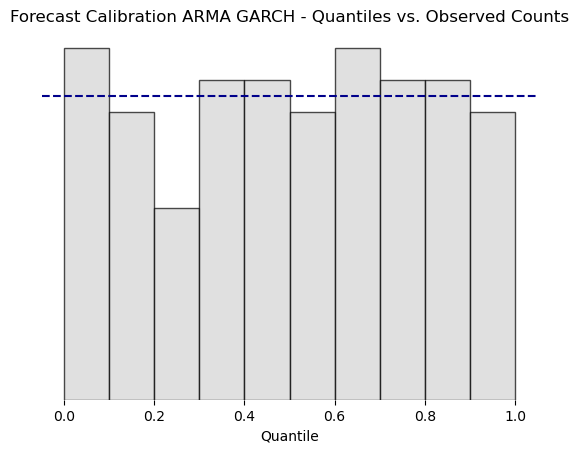

In [119]:
import matplotlib.pyplot as plt

bar_width = 0.1

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Calculate the mean of the y-values
mean_value = sum(counts) / len(counts)

# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])

# Plot mean
plt.axhline(y=mean_value, color='darkblue', linestyle='--', label='Mean')


# Alternatively: observed counts in each quantile range
plt.title('Forecast Calibration ARMA GARCH - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()